# Simulate trading results with GMF signal ONLY

## Imports

In [1]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import mlflow
import mlflow.keras
import numpy as np
from numpy import ndarray
import pandas as pd
from scipy.signal import medfilt
from scipy.ndimage.filters import gaussian_filter1d
import sys

import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)

import tensorflow as tf

%load_ext lab_black

sys.path.append("/Users/renero/Documents/SideProjects/trader/src")
sys.path.append("/Users/renero/Documents/SideProjects/trader/src/predictor")
sys.path.append("/Users/renero/Documents/SideProjects/trader/src/utils")
sys.path.append("/Users/renero/Documents/SideProjects/trader/src/indicators")
sys.path.append("/Users/renero/Documents/SideProjects/trader/src/portfoliomgmt")


from cs_dictionary import CSDictionary
from lstm import lstm_1layer, lstm_2layer
from sequences import sequences
from ticks import Ticks
from metrics import metrics
from portfoliomgmt.portfolio import Portfolio
from portfoliomgmt.stockpackage import StockPackage
from portfoliomgmt.toperation import TOperation

## Method to run the simulation

In [2]:
def simulate(ticks, verbose=False):
    portfolio = Portfolio()
    results = 0.0
    s = None
    actions = []
    earnings = []

    def print_summary(op, close, results):
        price = f"{row.close:+0.2}".ljust(5, "0")
        result = f"{results:>+5.2}".ljust(6, "0")
        print(f" -> {date:<12} {op:<4} {price:>7} {result:>11}")

    if verbose:
        print("    Date         Op     Price    Earnings")
        print("   ---------------------------------------")
    for i, row in ticks.data.iterrows():
        date = str(i)[:10]
        if row.gmf == 1.0:
            if s is None:
                if verbose:
                    print_summary("buy", row.close, results)
                s = StockPackage(date, row.close, 1, TOperation.bull)
                actions.append("buy")
            else:
                actions.append("---")
            earnings.append(results)
        elif row.gmf == -1.0:
            if s is not None:
                if verbose:
                    print_summary("sell", row.close, results)
                _, earn = s.sell(1, row.close, False)
                results += earn
                earnings.append(results)
                actions.append("sell")
                del s
                s = None
            else:
                actions.append("---")
                earnings.append(results)
        else:
            earnings.append(results)
            actions.append("---")

    if verbose:
        print("   ---------------------------------------")
        print(f"    Total: {results:+.2f}")

    return earnings, actions

In [3]:
# https://stackoverflow.com/a/41259922/892904
def align_yaxis(ax1, ax2):
    """Align zeros of the two axes, zooming them out by same ratio"""
    axes = (ax1, ax2)
    extrema = [ax.get_ylim() for ax in axes]
    tops = [extr[1] / (extr[1] - extr[0]) for extr in extrema]
    # Ensure that plots (intervals) are ordered bottom to top:
    if tops[0] > tops[1]:
        axes, extrema, tops = [list(reversed(l)) for l in (axes, extrema, tops)]

    # How much would the plot overflow if we kept current zoom levels?
    tot_span = tops[1] + 1 - tops[0]

    b_new_t = extrema[0][0] + tot_span * (extrema[0][1] - extrema[0][0])
    t_new_b = extrema[1][1] - tot_span * (extrema[1][1] - extrema[1][0])
    axes[0].set_ylim(extrema[0][0], b_new_t)
    axes[1].set_ylim(t_new_b, extrema[1][1])


def plot_marks_earnings(ticks, work):
    # Conversion of dates to matplotlib numeric references
    inxval = mdates.date2num(ticks.data.index.to_pydatetime())

    fig, ax1 = plt.subplots()
    fig.set_size_inches(20, 8)

    g = pd.Series(ticks.data.gmf)
    positives = g.where(g > 0.0).replace(np.nan, 0.0)
    negatives = g.where(g < 0.0).replace(np.nan, 0.0)

    ax1.plot(ticks.data.earnings, alpha=0.4, color="black")
    ax2 = ax1.twinx()

    ax2.plot(ticks.data.close, color="C0", alpha=0.8, linewidth=0.8)
    markerline, stemline, baseline = ax2.stem(
        inxval,
        positives / 10.0,
        markerfmt=" ",
        linefmt="C2-",
        basefmt="C7:",
        use_line_collection=True,
    )
    markerline, stemline, baseline = ax2.stem(
        inxval,
        negatives / 10.0,
        markerfmt=" ",
        linefmt="C3-",
        basefmt="C7:",
        use_line_collection=True,
    )
    plt.setp(baseline, "linewidth", 0.2)
    plt.setp(stemline, "linewidth", 1)
    plt.title(work)
    align_yaxis(ax2, ax1)
    plt.show()

## Parameter settings

In [4]:
my_file = {}
my_yaml = {}
my_argv = {}
mtw = {}
mfw = {}
sig = {}

my_file["EURUSD"] = "../data/EURUSD/EURUSD_2018_2020.csv"
my_file["DAX"] = "../data/^GDAXI/dax_2018_2019.csv"
my_yaml["EURUSD"] = "../src/predictor/params.eurusd.yaml"
my_yaml["DAX"] = "../src/predictor/params.dax.yaml"
my_argv["EURUSD"] = ["", "-c", my_yaml["EURUSD"], "-f", my_file["EURUSD"], "train"]
my_argv["DAX"] = ["", "-c", my_yaml["DAX"], "-f", my_file["DAX"], "train"]

mtw["EURUSD"] = 7
mfw["EURUSD"] = 3
sig["EURUSD"] = 5
mtw["DAX"] = 5
mfw["DAX"] = 5
sig["DAX"] = 2

In [5]:
work = "EURUSD"

params = CSDictionary(args=my_argv[work])
ticks = Ticks(params, params.input_file).scale()
ticks.append_indicator(["trend", "median_filter", "change"])
ticks.append_indicator(
    "gmf", monotonic_window=mtw[work], mf_window=mfw[work], sigma=sig[work]
)
ticks.data["earnings"], ticks.data["operations"] = simulate(ticks)

2020-09-26 11:07:16 - INFO  - CSDictionary:__init__           - Using configuration parameters from: ../src/predictor/params.eurusd.yaml


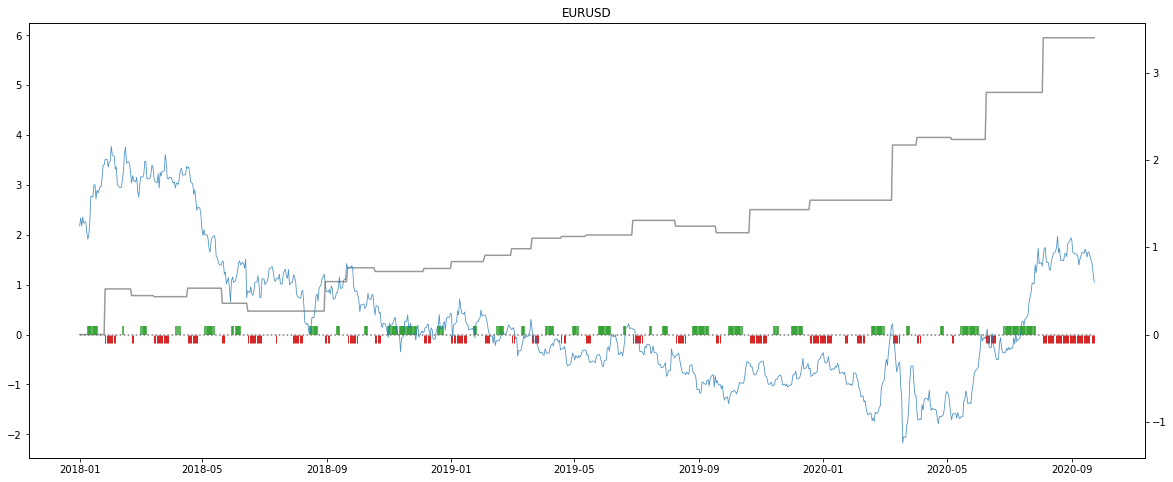

In [6]:
plot_marks_earnings(ticks, work)

In [7]:
work = "DAX"

params = CSDictionary(args=my_argv[work])
ticks = Ticks(params, params.input_file).scale()
ticks.append_indicator(["trend", "median_filter", "change"])
ticks.append_indicator(
    "gmf", monotonic_window=mtw[work], mf_window=mfw[work], sigma=sig[work]
)
ticks.data["earnings"], ticks.data["operations"] = simulate(ticks)

2020-09-26 11:07:17 - INFO  - CSDictionary:__init__           - Using configuration parameters from: ../src/predictor/params.dax.yaml


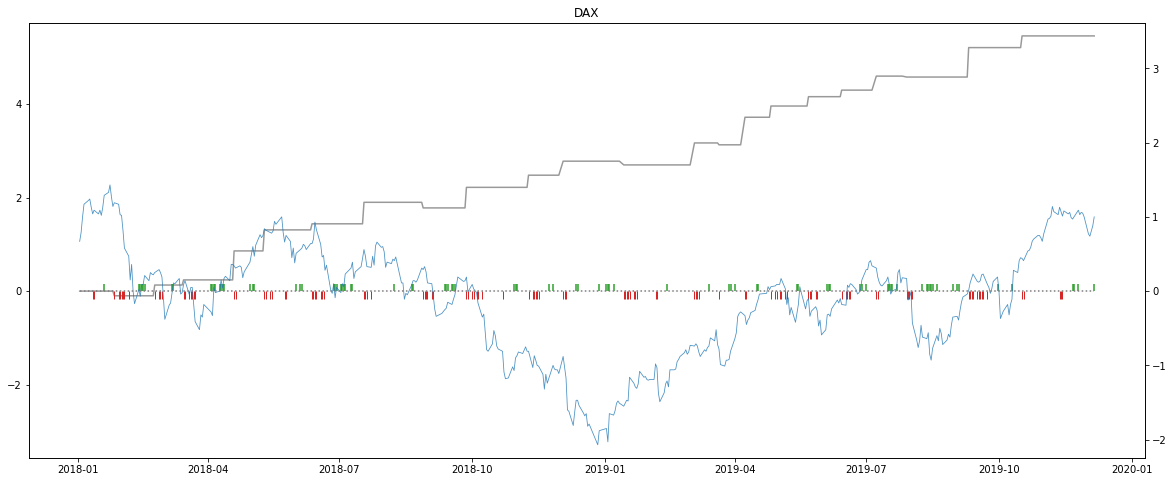

In [8]:
plot_marks_earnings(ticks, work)